# Machine-Learning-and-Statistics-Project 2020

***

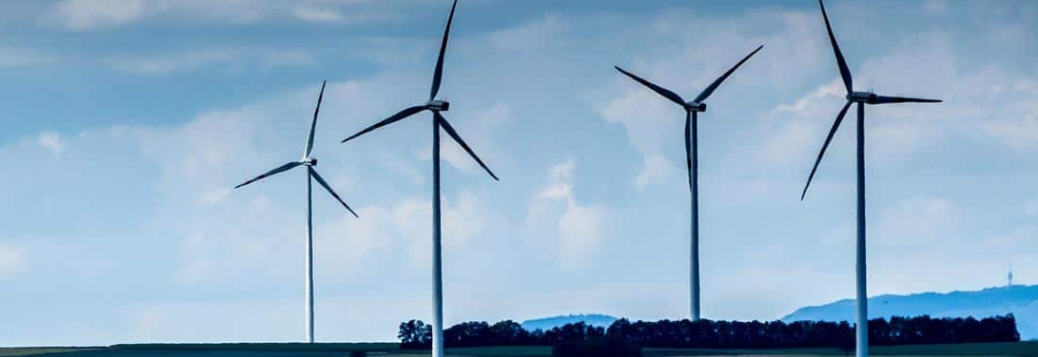

## Introduction

This project deploys a web service that uses machine learning to make predictions based on the data set powerproduction. The goal is to produce a model that accurately predicts wind turbine power output from wind speed values. A web service that responds with predicted power values based on speed values sent as HTTP requests is also included. 


#### Task objectives:
- Understand the impact of the operation of turbines on the dataset.
- Explore the Power production dataset.
- Explore models
- Determine model to use
- Develop web service

### How do wind turbines operate?

The ESB provide detail on how wind turbines operate.  They operate automatically, self-starting when the wind speed reaches an average of about three to five meters per second (about 10 mph), equal to that of a gentle breeze which otherwise would only be strong enough to rustle leaves and light twigs. The output increases linearly with the wind speed until the wind speed reaches 13 to 14 meters per second (about 30 mph) equal to that of a strong breeze. At this point, the wind turbine will reach its maximum generating capacity.

If the average wind exceeds the maximum operational limit of 25 meters per second, equal to that of a storm, the wind turbine shuts down by the feathering of blades, in order to avoid excessive wear-and-tear. Upon the average wind speed dropping back below 25 m/s the wind turbine will restart. [6]

### Explore the dataset

In [1]:
# Import libraries
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import numpy as np

In [2]:
# Make matplotlib show interactive plots in the notebook.
%matplotlib inline

# Apply the default seaborn settings.
sns.set()

#Set plot style.
plt.style.use("ggplot")

# Plot size.
plt.rcParams['figure.figsize'] = [14, 8]

In [3]:
# Import the power production dataset and call it pp
pp = pd.read_csv("powerprod.csv")

In [4]:
pp.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
speed,500.0,12.590398,7.224991,0.0,6.32475,12.5505,18.77525,25.000
power,500.0,48.014584,41.614572,0.0,5.28800,41.6455,93.53700,113.556


In [5]:
pp.head()

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0


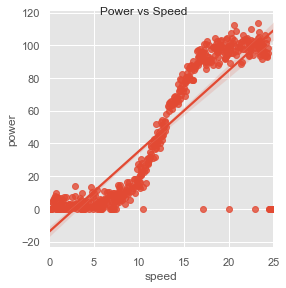

In [6]:
p = sns.pairplot(data=pp,y_vars=['power'],x_vars=['speed'],kind='reg',height=4).fig.suptitle('Power vs Speed')

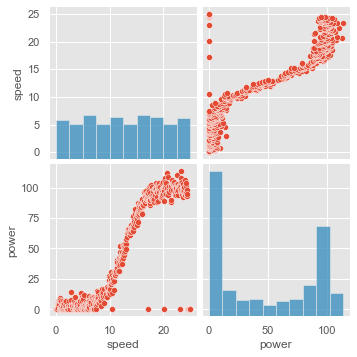

In [7]:
sns.pairplot(pp)

### Observations

The powerproduction dataset appears to be in line with information provided by the ESB on how turbines operate:

- Once speed hits 3 - 5 m/s, they start to operate.
- Output increases linearly until it reaches 25 m/s which is maximum capacity.
- Turbines shut down once the maximum limit has been reached.

A linear correlation is clear once the turbine is fully operational (approx 10 - 25 m/s).<br>

#### Should values imported for analysis be discounted?
 
In his "Deep learning with Python" book, Francois Chollet [9] says that "In general, with neural networks, it’s safe to input missing values as 0, with the condition that 0 isn’t already a meaningful value. The network will learn from exposure to the data that the value 0 means missing data and will start ignoring the value."

Due to operational constraints of the turbines, I believe it makes sense to include values when they are operational.  The max value in 25 m/s (per the summary table  above) so I only need to  exclude values below 5 which is the maximum of the start point.
This means that we are excluding almost 20% of the dataset. 

In [8]:
j = pp[pp.speed < 5].count()
j

speed    94
power    94
dtype: int64

In [9]:
# Exclude values less than 5 m/s.
pp1 = pp[pp['speed'] > 5]
pp1

,speed,power
94,5.030,9.519
95,5.080,2.973
96,5.130,8.623
97,5.180,4.525
98,5.205,0.932
...,...,...
495,24.775,0.000
496,24.850,0.000
497,24.875,0.000
498,24.950,0.000


In [10]:
pp1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
speed,406.0,14.954052,5.832351,5.03,10.0475,15.1775,19.81375,25.000
power,406.0,58.427273,39.411064,0.00,13.7765,69.4735,95.80725,113.556


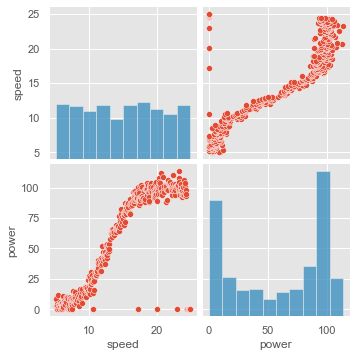

In [11]:
sns.pairplot(pp1)

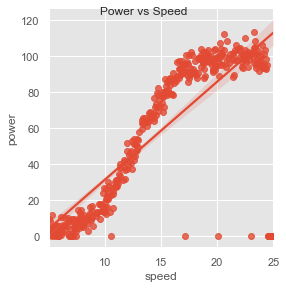

In [12]:
p = sns.pairplot(data=pp1,y_vars=['power'],x_vars=['speed'],kind='reg',height=4).fig.suptitle('Power vs Speed')

***

## Explore models

### Linear Regression Model

Linear regression is a statistical model that examines the linear relationship between variables, a dependent variable and independent variable.  Regression models describe the relationship between variables by fitting a line to the observed data. Regression allows estimation  of how a dependent variable changes as the independent variable changes.

In [13]:
# Import libraries
import sklearn.linear_model as lin

In [14]:
# Assign features and labels to the working data set
x = pp1.iloc[:,:-1].to_numpy()
y = pp1['power'].to_numpy()
x = x.reshape(-1, 1)

#### Train the Model
Build the linear regression model using the training data. This involves creating a Linear Regression model object and one call to its 'fit' method.

In [15]:
model = lin.LinearRegression()
model.fit(x, y)

LinearRegression()

#### Interpreting The Coefficients
The intercept term (β0), which is equal to the mean power output when all of the other coefficients are set equal to their mean values.  A positive coefficient means that power output increases as speed increases which we know from our original review of the dataset. 

In [16]:
r = model.score(x, y)
p = [model.intercept_, model.coef_[0]]

In [17]:
# The intercept (often labeled the constant) is the expected mean value of Y when all X=0. 
r

0.6475825358486247

In [18]:
p

[-22.889650730441012, 5.437785399538167]

### Predict
Now that the model is built, its performance can be tested by using the 'predict' function within the LinearRegression model class.

Text(0, 0.5, 'Predicted Power (kWh)')

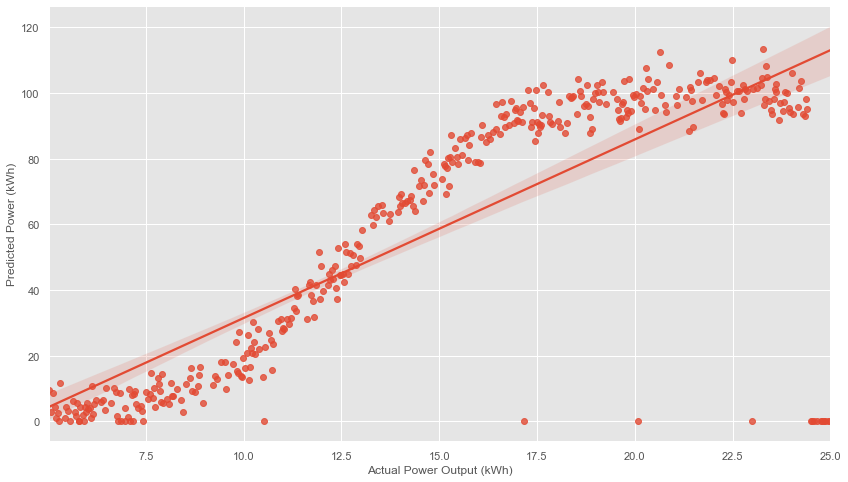

In [19]:
sns.regplot(x=x, y=y)
plt.xlabel('Actual Power Output (kWh)')
plt.ylabel('Predicted Power (kWh)')

In [20]:
# Adapted from https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/models.ipynb 
def f(x, p):
    return p[0] + x * p[1]

In [21]:
f(20, p)

85.86605726032232

#### Conclusion

This plot tells us that our model is not accurate.  Linear regression does not suit.
Linear regression is not very flexible and not very accurate due to its rigidity. The model does not capture underlying relationship between the power and speed.

### Keras Neural network

#### Create Keras Model

Models in Keras are defined as a sequence of layers.  A sequential model is created with layers added until the network architecture is working properly.

The input layer needs the right number of input features. This can be specified when creating the first layer with the input_dim argument.

Fully connected layers are defined using the Dense class. We can specify the number of neurons or nodes in the layer as the first argument, and specify the activation function using the activation argument.

In [22]:
import tensorflow.keras as kr

In [23]:
# Adapted from https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/keras-neurons.ipynb
# Create a new neural network.
m = kr.models.Sequential()

# Add multiple layers, initialised with weight and bias.
m.add(kr.layers.Dense(66, input_dim=1, activation="relu",kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
m.add(kr.layers.Dense(32, activation='sigmoid'))
m.add(kr.layers.Dense(16, activation='sigmoid'))
m.add(kr.layers.Dense(1, activation=None))

#### Compile Model

Compiling the model automatically chooses the best way to represent the network for training and making predictions.

Training a network means finding the best set of weights to map inputs to outputs in our dataset.

The loss function is specified to evaluate a set of weights, the optimizer is used to search through different weights for the network and any optional metrics we would like to collect and report during training.

The Mean Squared Error, or MSE, loss is the default loss to use for regression problems.

The optimizer as the efficient stochastic gradient descent algorithm “adam“. This is a popular version of gradient descent because it automatically tunes itself and gives good results in a wide range of problems. 

In [24]:
# Compile the model.
m.compile(loss="mean_squared_error", optimizer="adam")

### Fit the model

Training occurs over epochs and each epoch is split into batches.

Epoch: One pass through all of the rows in the training dataset.
Batch: One or more samples considered by the model within an epoch before weights are updated.
One epoch is comprised of one or more batches, based on the chosen batch size and the model is fit for many epochs. 

What is the Difference Between a Batch and an Epoch in a Neural Network?
The training process will run for a fixed number of iterations through the dataset called epochs, that we must specify using the epochs argument. We must also set the number of dataset rows that are considered before the model weights are updated within each epoch, called the batch size and set using the batch_size argument.

These configurations can be chosen experimentally by trial and error. We want to train the model enough so that it learns a good (or good enough) mapping of rows of input data to the output classification. The model will always have some error, but the amount of error will level out after some point for a given model configuration. This is called model convergence.

By looking at the numbers, you should be able to see the loss decrease and the accuracy increase over time. At this point, you can experiment with the hyper-parameters and neural network architecture. Ru

In [25]:
x = pp1.iloc[:,:-1].to_numpy()
y = pp1['power'].to_numpy()
x = x.reshape(-1, 1)

In [26]:
# fit the keras model on the dataset
m.fit(x, y, epochs=500, batch_size=12)
m.summary()

Epoch 1/500
34/34 [==============================] - 0s 879us/step - loss: 5155.0808
Epoch 2/500
34/34 [==============================] - 0s 879us/step - loss: 4734.3870
Epoch 3/500
34/34 [==============================] - 0s 727us/step - loss: 4720.4673
Epoch 4/500
34/34 [==============================] - 0s 909us/step - loss: 4423.1626
Epoch 5/500
34/34 [==============================] - 0s 818us/step - loss: 4197.5067
Epoch 6/500
34/34 [==============================] - 0s 818us/step - loss: 4597.0181
Epoch 7/500
34/34 [==============================] - 0s 757us/step - loss: 4196.6905
Epoch 8/500
34/34 [==============================] - 0s 758us/step - loss: 4512.1722
Epoch 9/500
34/34 [==============================] - 0s 758us/step - loss: 4156.0182
Epoch 10/500
34/34 [==============================] - 0s 727us/step - loss: 4221.1610
Epoch 11/500
34/34 [==============================] - 0s 849us/step - loss: 4024.8103
Epoch 12/500
34/34 [==============================] - 0s 818us/

34/34 [==============================] - 0s 940us/step - loss: 1880.7631
Epoch 96/500
34/34 [==============================] - 0s 939us/step - loss: 1751.3990
Epoch 97/500
34/34 [==============================] - 0s 939us/step - loss: 1834.6256
Epoch 98/500
34/34 [==============================] - 0s 939us/step - loss: 1656.9711
Epoch 99/500
34/34 [==============================] - 0s 871us/step - loss: 1749.1713
Epoch 100/500
34/34 [==============================] - 0s 909us/step - loss: 1804.7543
Epoch 101/500
34/34 [==============================] - 0s 909us/step - loss: 1762.1893
Epoch 102/500
34/34 [==============================] - 0s 940us/step - loss: 1606.2507
Epoch 103/500
34/34 [==============================] - 0s 940us/step - loss: 1581.7963
Epoch 104/500
34/34 [==============================] - 0s 1ms/step - loss: 1555.8194
Epoch 105/500
34/34 [==============================] - 0s 1ms/step - loss: 1477.8901
Epoch 106/500
34/34 [==============================] - 0s 1ms/ste

34/34 [==============================] - 0s 1ms/step - loss: 610.3137
Epoch 191/500
34/34 [==============================] - 0s 1ms/step - loss: 649.9724
Epoch 192/500
34/34 [==============================] - 0s 849us/step - loss: 595.1236
Epoch 193/500
34/34 [==============================] - 0s 848us/step - loss: 483.9362
Epoch 194/500
34/34 [==============================] - 0s 849us/step - loss: 548.2007
Epoch 195/500
34/34 [==============================] - 0s 909us/step - loss: 552.5378
Epoch 196/500
34/34 [==============================] - 0s 908us/step - loss: 539.8585
Epoch 197/500
34/34 [==============================] - 0s 909us/step - loss: 490.8792
Epoch 198/500
34/34 [==============================] - 0s 910us/step - loss: 546.0434
Epoch 199/500
34/34 [==============================] - 0s 909us/step - loss: 514.6897
Epoch 200/500
34/34 [==============================] - 0s 908us/step - loss: 532.5555
Epoch 201/500
34/34 [==============================] - 0s 849us/step - l

34/34 [==============================] - 0s 879us/step - loss: 311.7293
Epoch 286/500
34/34 [==============================] - 0s 879us/step - loss: 393.5910
Epoch 287/500
34/34 [==============================] - 0s 909us/step - loss: 358.6826
Epoch 288/500
34/34 [==============================] - 0s 909us/step - loss: 360.7989
Epoch 289/500
34/34 [==============================] - 0s 879us/step - loss: 308.8973
Epoch 290/500
34/34 [==============================] - 0s 939us/step - loss: 284.3045
Epoch 291/500
34/34 [==============================] - 0s 909us/step - loss: 318.2235
Epoch 292/500
34/34 [==============================] - 0s 879us/step - loss: 314.5890
Epoch 293/500
34/34 [==============================] - 0s 848us/step - loss: 302.0902
Epoch 294/500
34/34 [==============================] - 0s 849us/step - loss: 216.4761
Epoch 295/500
34/34 [==============================] - 0s 879us/step - loss: 326.5549
Epoch 296/500
34/34 [==============================] - 0s 909us/step

Epoch 381/500
34/34 [==============================] - 0s 971us/step - loss: 253.8305
Epoch 382/500
34/34 [==============================] - 0s 939us/step - loss: 342.1400
Epoch 383/500
34/34 [==============================] - 0s 969us/step - loss: 231.1835
Epoch 384/500
34/34 [==============================] - 0s 910us/step - loss: 274.0258
Epoch 385/500
34/34 [==============================] - 0s 970us/step - loss: 388.2303
Epoch 386/500
34/34 [==============================] - 0s 940us/step - loss: 322.5588
Epoch 387/500
34/34 [==============================] - 0s 939us/step - loss: 282.7983
Epoch 388/500
34/34 [==============================] - 0s 848us/step - loss: 437.8187
Epoch 389/500
34/34 [==============================] - 0s 848us/step - loss: 351.7807
Epoch 390/500
34/34 [==============================] - 0s 940us/step - loss: 335.0227
Epoch 391/500
34/34 [==============================] - 0s 910us/step - loss: 339.4954
Epoch 392/500
34/34 [==============================] -

34/34 [==============================] - 0s 1ms/step - loss: 199.8812
Epoch 478/500
34/34 [==============================] - 0s 1ms/step - loss: 197.6175
Epoch 479/500
34/34 [==============================] - 0s 1000us/step - loss: 348.8952
Epoch 480/500
34/34 [==============================] - 0s 1ms/step - loss: 282.9238
Epoch 481/500
34/34 [==============================] - 0s 1ms/step - loss: 284.1156
Epoch 482/500
34/34 [==============================] - 0s 1ms/step - loss: 315.0115
Epoch 483/500
34/34 [==============================] - 0s 1ms/step - loss: 321.7745
Epoch 484/500
34/34 [==============================] - 0s 1ms/step - loss: 204.6026
Epoch 485/500
34/34 [==============================] - 0s 1ms/step - loss: 236.0202
Epoch 486/500
34/34 [==============================] - 0s 1ms/step - loss: 329.9473
Epoch 487/500
34/34 [==============================] - 0s 1ms/step - loss: 346.3897
Epoch 488/500
34/34 [==============================] - 0s 1000us/step - loss: 399.3771


### Evaluate 
We have trained our neural network on the entire dataset and we can evaluate the performance of the network on the same dataset.

This will only give us an idea of how well we have modeled the dataset (e.g. train accuracy), but no idea of how well the algorithm might perform on new data. We have done this for simplicity, but ideally, you could separate your data into train and test datasets for training and evaluation of your model.

You can evaluate your model on your training dataset using the evaluate() function on your model and pass it the same input and output used to train the model.

This will generate a prediction for each input and output pair and collect scores, including the average loss and any metrics you have configured, such as accuracy.

The evaluate() function will return a list with two values. The first will be the loss of the model on the dataset and the second will be the accuracy of the model on the dataset. We are only interested in reporting the accuracy, so we will ignore the loss value.

In [27]:
scores = m.evaluate(x, y, verbose=0)
print(scores)
# print("%s: %.2f%%" % (m.metrics_names[1], scores[1]*100))

305.22149658203125


#### Predict

In [30]:
result = m.predict([20])
#type(result[0])
#result = np.ndarray.item(result[0])
result

array([[90.30831]], dtype=float32)

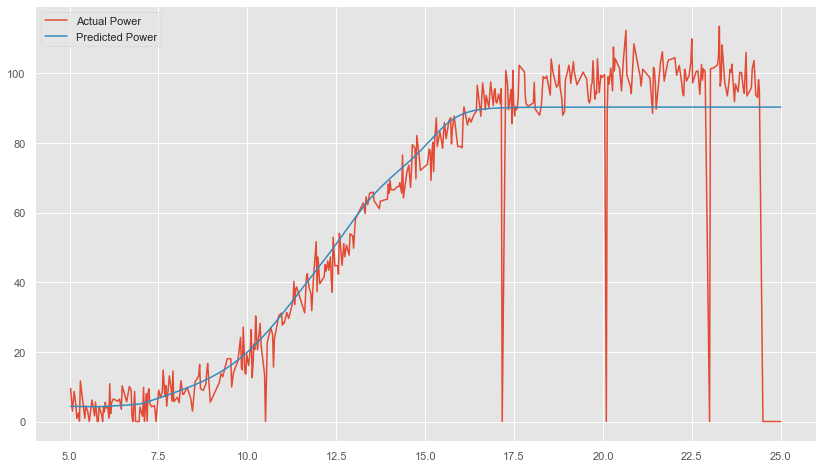

In [29]:
# Plot Data and Predictions to Visualise
plt.plot(x, y, label='Actual Power')
plt.plot(x, m.predict(x), label='Predicted Power')
plt.legend()

### Conclusion

Keras is a flexible neural network.  It has predicted reasonably accurately wind speed in the rante 5 - 17.5.  
It has underestimated over 17.5.




### Choosing an Appropriate Model
Choosing an appropriate model depends on a number of factors, including:

- The size of the data, as some models perform better on larger or smaller data sets

- The distribution of the data, as some models assume the features with a dataset follow a specific statistical distribution

- The relationship between the features and labels (linear or non-linear, additive or multiplicative, etc.)
Wind turbines produce electricity approximately 85% of the time. The other 15% of the time they are not turning for reasons, such as: very low wind speeds, very high wind speeds, and maintenance/repair work.


The general goal of machine learning is to build models that can learn from data without being explicitly programmed. Supervised learning refers to the fact that each sample within the data being used to build the system contains an associated label. The goal is to build a model that can accurately predict the value of the label when presented with new data. The supervised learning model takes the form:

Y=f(x)
   
Where the label is assumed to be some general function of the input features. 

Power curve of a wind turbine depicts the relationship between output power and wind speed.  Accurate models of power curves can play an important role in improving the performance of wind energy based systems. This notebook presents a detailed review of different approaches for modelling the wind turbine power curve. [1]



***

## References
[1] https://www.hindawi.com/journals/jen/2016/8519785/<br>
[2] http://ieeexplore.ieee.org/iel7/5165391/5433168/06894235.pdf <br>
[3] https://keras.io/getting_started/intro_to_keras_for_engineers <br>
[4] https://medium.com/towards-artificial-intelligence/building-neural-networks-from-scratch-with-python-code-and-math-in-detail-i-536fae5d7bbf <br>
[5] https://blogs.oracle.com/datascience/supervised-learning-with-python<br>
[6] https://scikit-learn.org/stable/index.html <br>
[7] https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/keras-neurons.ipynb<br>
[8] https://www.esb.ie/tns/education-hub/future-energy/wind-energy<br>
[9] http://faculty.neu.edu.cn/yury/AAI/Textbook/Deep%20Learning%20with%20Python.pdf Deep Learning with Python by Francois Chollet <br>.

### The End